# Fine-movement characterization

In [2]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from datetime import datetime
from scipy.interpolate import interp1d

# --Machine learning and statistics+
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import umap

from one.api import ONE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
# from plotting_functions import bins_per_trial_phase, broader_label
from data_processing import process_quiescence
from wheel_functions import wheel_trial_epoch
one = ONE(base_url='https://alyx.internationalbrainlab.org')

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/api.py:1577: UserWarning: Newer cache tables require ONE version 2.7 or greater
  warnings.warn(f'Newer cache tables require ONE version {min_version} or greater')


## Load data

In [3]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/'
data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/'
os.chdir(data_path)
session_all = pickle.load(open('last_3_training_2024-04-23', 'rb'))

In [4]:
threshold = 0.2 # Need to check if this makes sense
min_period = 400 # This is to match the minimum length of quiescence periods
bin_size = 0.05

# Save data of all sessions for latter
processes_quiescence_all = defaultdict(list)
perf_idx = pd.DataFrame(columns=['performance_easy', 'idx'])

# Loop through animals
mouse_names = list(session_all.keys())
for m, mouse_name in enumerate(mouse_names[0:1]):
    processes_quiescence_all[mouse_name] = {}

    # Find data of interest
    mouse_data = session_all[mouse_name]
    mouse_session_num = np.max(mouse_data['training_day'])
    use_data = mouse_data.loc[mouse_data['training_day'] >= mouse_session_num]

    # Loop through sessions
    mouse_sessions = use_data['session'].unique()
    for s, session in enumerate(mouse_sessions):
        
        session_trials = use_data.loc[use_data['session']==session]
        session_trials['index'] = np.arange(0, len(session_trials))
        
        df = wheel_trial_epoch(one, session_trials, session, bin_size, threshold, min_period).dropna()  
    #     df = df[['trial', 'wheel', 'movement', 'trial_epoch', 'feedback',
    #    'next_feedback', 'signed_contrast', 'response', 'reaction', 'choice',
    #    'probabilityLeft']].drop_duplicates()
    
        processed_quiescence = process_quiescence(df)

        # Save
        processes_quiescence_all[mouse_name][session] = processed_quiescence
        
        # Save performance also
        perf_mouse = pd.DataFrame(columns=['performance_easy', 'idx'], index=range(1))
        perf_mouse['idx'] = session
        perf_mouse['performance_easy'] = np.nanmean(session_trials['correct_easy'])
        
        # Save performance results
        if s == 0:
            perf_idx = perf_mouse
        else:
            perf_idx = perf_idx.append(perf_mouse)

/Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-02-10/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 4.15M/4.15M [00:01<00:00, 2.48MB/s]
/Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-02-10/001/alf/_ibl_wheel.position.npy: 100%|██████████| 4.15M/4.15M [00:01<00:00, 3.39MB/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/data_processing.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['movement_duration'][1:] = np.diff(new_df['movement_onset'])


63
79
258
289
333
364
390
424
462
516
710
944
983


# Loop through movements and characterize

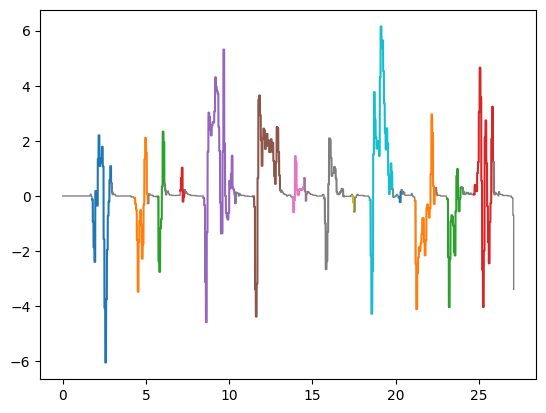

In [87]:
reduced = processed_quiescence[processed_quiescence['movement'].shift(1) != processed_quiescence['movement']].reset_index()
movements = reduced['movement_onset'][0:30]

for m, movement_onset in enumerate(movements[:-1]):
    movement_init = movement_onset
    movement_end = movements[m+1]
    movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
    next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movements[m+1], 'movement'])[0]
    movement_time = df.loc[(df['time']>movement_init-.05) & (df['time']<=movement_end+.05), 'time']
    movement_wheel = df.loc[(df['time']>movement_init-.05) & (df['time']<=movement_end+.05), 'wheel']
    if movement_bool == 1.0:
        plt.plot(movement_time, movement_wheel)
    else:
        plt.plot(movement_time, movement_wheel, color='grey', linewidth=1)


## Color code by trial epoch

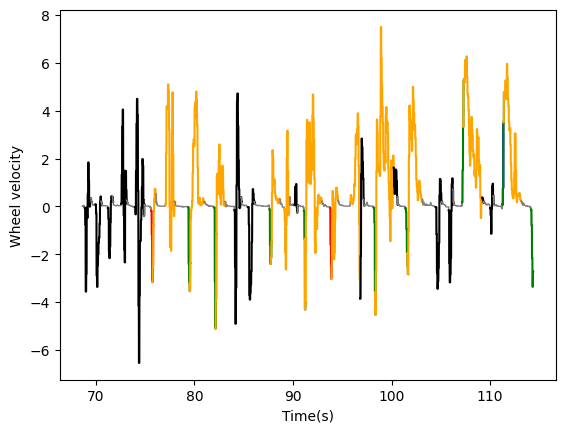

In [121]:
movements = processed_quiescence['movement_onset'][150:250].reset_index()
trial_epochs = ['trial_start', 'quiescence', 'stim_on', 'movement', 'post_choice']
colors_to_use_correct = ['black', 'purple', 'blue', 'green', 'orange']
colors_to_use_incorrect = ['black', 'purple', 'blue', 'red', 'orange']

for m, movement_onset in enumerate(movements['movement_onset'][:-1]):
    movement_init = movement_onset
    movement_end = movements['movement_onset'][m+1]
    movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
    next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_end, 'movement'])[0]
    movement_time = df.loc[(df['time']>movement_init-.05) & (df['time']<=movement_end+.05), 'time']
    movement_wheel = df.loc[(df['time']>movement_init-.05) & (df['time']<=movement_end+.05), 'wheel']

    # Plot
    feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'feedback'])[0]
    trial_epoch = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial_epoch'])[0]
    if feedback == 1.:
        colors = colors_to_use_correct[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
    else:
        colors = colors_to_use_incorrect[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
        
    if movement_bool == 1.0:
        plt.plot(movement_time, movement_wheel, color=colors, label=trial_epoch)
    else:
        plt.plot(movement_time, movement_wheel, color='grey', linewidth=1)

    plt.xlabel('Time(s)')
    plt.ylabel('Wheel velocity')

In [ ]:
# TODO
# for a single movement plot derivatives, color code by trial epoch

In [98]:
np.where(np.array(trial_epochs)==trial_epoch)[0][0]

0

In [91]:
np.where(trial_epochs==trial_epoch)

(array([], dtype=int64),)

(119277.0, 127914.0)

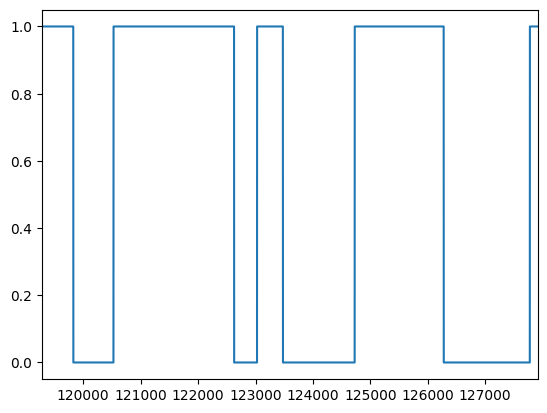

In [34]:
plt.plot(df['movement'])
plt.xlim([119277, 127914])

In [12]:
df[movement_init:movement_end]['time']

4514631    4512.254638
4514632    4512.255638
4514633    4512.256638
4514634    4512.257638
4514635    4512.258638
              ...     
4515029    4512.652638
4515030    4512.653638
4515031    4512.654638
4515032    4512.655638
4515033    4512.656638
Name: time, Length: 403, dtype: float64

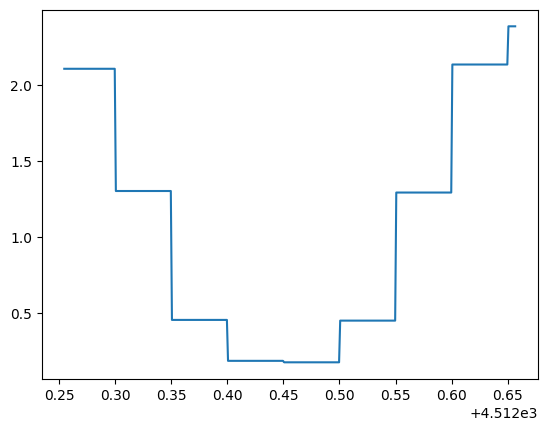

In [11]:
plt.plot(df[movement_init:movement_end]['time'], df[movement_init:movement_end]['wheel'])

In [ ]:
movement_snippet = df[]